In [59]:
#core
library(topicmodels)
library(tidytext)
library(tidyverse)
library(stringi)
#calculations
library(proxy)
library(ineq)
#dendrograms
library(ape)
library(phylogram)
library(ggdendro)
#visuals
library(paletteer)
library(ggrepel)
library(plotly)
library(DT)
library(grid)


options(repr.plot.width = 6, repr.plot.height = 4)
source("src/poem_sampler.R")

In [184]:
# loads prepared LDA model
load("data/ru_lda.Rda")

# extract topic probabilities in documents
ru_gamma = tidy(ru_lda, matrix = "gamma")
# extract word probabilities in topics
ru_beta = tidy(ru_lda, matrix = "beta")

# get top 20 words per each topic
top_terms = ru_beta %>%
  group_by(topic) %>%
  top_n(20, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

# topic labels, top n words

n_words = 5

topic_labels = top_terms %>%
  group_by(topic) %>%
  top_n(n_words, beta) %>%
  summarise(label=paste(term, collapse=" ")) %>%
  mutate(label = paste(topic, label, sep="_"))



## 0. Preparations

In [185]:
#drop mysterious NA poems
ru_gamma = ru_gamma  %>% 
  filter(!str_detect(document, "^NA"))


### pull list of unique poems for later sampling, fix ids

unique_poems = ru_gamma  %>% 
    select(document) %>%
    unique()  %>% 
    separate(document, c("id", "author", "first_line", "meter", "clausula"), sep="_")  %>%
    ungroup()  %>% 
    mutate(id = row_number())


### get ru_gamma separated, add topic labels to it
### also redo fake ids into normal ids

ru_gamma_separated = ru_gamma  %>% 
    separate(document, c("id", "author", "first_line", "meter", "clausula"), sep="_")  %>% 
    left_join(topic_labels, by="topic")  %>% 
    mutate(id = rep(1:nrow(unique_poems), 120))


### get count of meters
meter_count = unique_poems  %>% 
    count(meter, sort=T)  %>% 
    filter(!str_detect(meter,"NA"))


### get count of metrical forms (meter + clausula)
meter_claus_count = unique_poems  %>% 
    unite("meter", meter:clausula)  %>% 
    count(meter, sort=T)  %>% 
    filter(!str_detect(meter,"NA_"))


print(ru_gamma_separated)
print(meter_claus_count)
print(meter_count)


# A tibble: 6,888,000 x 8
      id author    first_line          meter clausula topic   gamma label       
   <int> <chr>     <chr>               <chr> <chr>    <int>   <dbl> <chr>       
 1     1 Клушин А… Не-титла-знамениты  NA    NA           1 3.12e-3 1_дождь кап…
 2     2 Ржевский… Случилося-двоим     Явол… вольн        1 9.52e-4 1_дождь кап…
 3     3 Цветаева… Вы-идущие-мимо-меня Ан3   мж           1 2.17e-3 1_дождь кап…
 4     4 Муравьев… Успех-твой-первый-… Я4    жм           1 5.49e-4 1_дождь кап…
 5     5 Сумароко… Не-гордитесь-красн… NA    NA           1 3.12e-3 1_дождь кап…
 6     6 Попугаев… Ликуй-Парнас-вспле… Я4    жм           1 1.41e-3 1_дождь кап…
 7     7 Муравьев… Как-яры-волны-в-мо… Я4    жжм          1 9.09e-4 1_дождь кап…
 8     8 Муравьев… Сей-непорочнейшей-… Я6    жжмм         1 3.45e-3 1_дождь кап…
 9     9 Блок А.А. Ты-была-светла-до-… Х4    дм           1 2.33e-3 1_дождь кап…
10    10 Попов М.… Пожалуй-перестань-… Явол… вольн        1 3.23e-3 1_дождь кап…
# 

## 0.1. Get some visualizations of random topics

In [ ]:
## r

## topic 105

rand_theme = sample(c(1:120), 1)

top_terms %>%
  filter(topic == rand_theme) %>%
  mutate(term = reorder(term, beta)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  labs(y="Probability of a word (beta)",
       x="Top terms") +
  coord_flip() +
  theme_classic() +
      theme(
        axis.text.y = element_text(size=14,face = "bold"),
         axis.title=element_text(size=14)) +
#  scale_fill_paletteer_d(wesanderson, Royal1)
  scale_fill_manual(values=paletteer_d(package="wesanderson", palette = "Royal1")[2]) +
    labs(title = paste("Topic", rand_theme, sep=" "))


In [ ]:
rand_theme = sample(c(1:120), 1)

top_terms %>%
  filter(topic == rand_theme) %>%
  mutate(term = reorder(term, beta)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  labs(y="Probability of a word (beta)",
       x="Top terms") +
  coord_flip() +
  theme_classic() +
      theme(
        axis.text.y = element_text(size=14,face = "bold"),
         axis.title=element_text(size=14)) +
#  scale_fill_paletteer_d(wesanderson, Royal1)
  scale_fill_manual(values=paletteer_d(package="wesanderson", palette = "Royal1")[1])

In [ ]:
rand_theme = sample(c(1:120), 1)

top_terms %>%
  filter(topic == rand_theme) %>%
  mutate(term = reorder(term, beta)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  labs(y="Probability of a word (beta)",
       x="Top terms") +
  coord_flip() +
  theme_classic() +
      theme(
        axis.text.y = element_text(size=14,face = "bold"),
         axis.title=element_text(size=14)) +
  scale_fill_manual(values=paletteer_d(package="wesanderson", palette = "Darjeeling1")[2])

## 0.2. Documents as topics

In [ ]:
￼
twopoems = ru_gamma_separated %>% 
  filter(str_detect(first_line, "Выхожу-один-я|Ах!-почто-за"))

twopoems %>%
  ggplot(aes(topic, gamma, group=author, color=author)) +
  labs(x="Topics",
       y="Probability of topics (gamma)") +
  geom_line(size=1) +
  theme_classic() +


 # geom_text(data = twopoems %>% filter(gamma > 0.05), 
 #           aes(label=factor(label), vjust=-0.5)) +
  theme(axis.text.x = element_blank(),
        axis.text.y = element_text(size=14),
        axis.title=element_text(size=14)) +


  scale_color_paletteer_d(wesanderson, Royal1)



In [ ]:
 two_meters = unique_poems %>%
    unite("m_form", meter:clausula)  %>% 
    filter(m_form %in% c("Х5_жм", "Х4_дм")) %>% 
    group_by(m_form)  %>% 
    sample_n(20) %>% 
    ungroup()  %>% 
    select(id)


ru_gamma_separated  %>% 
  right_join(two_meters, by="id") %>%
  ggplot(aes(topic, gamma, group=id, color=meter)) +
  labs(x="Topics",
       y="Probability of topics (gamma)") +
  geom_line(alpha=0.5) +
  theme_classic() +

  theme(axis.text.x = element_blank(),
        axis.text.y = element_text(size=14),
        axis.title=element_text(size=14)) +


  scale_color_paletteer_d(wesanderson, Royal1)
    

In [ ]:
ru_gamma_separated  %>% 
  right_join(two_meters, by="id") %>%
  group_by(topic, meter)  %>% 
  summarise(m_gamma = mean(gamma))  %>% 
  ggplot(aes(topic, m_gamma, group=meter, color=meter)) +
  labs(x="Topics",
       y="Probability of topics (gamma)") +
  geom_line(alpha=0.7) +
  theme_classic() +

  theme(axis.text.x = element_blank(),
        axis.text.y = element_text(size=14),
        axis.title=element_text(size=14)) +


  scale_color_paletteer_d(wesanderson, Royal1)
    

## 1. Equal sample meters and get Trochee-5 z-scores

what we are doing here is looking at distinctive topics for random sample of Trochee-5 in the context of equal samples of other meters popular enough.

1) Sample n (200) poems from meters that have at least n*2 poems;  
2) Measure zscores (normalized deviation from the mean) for summarised gamma for each meter sample

In [ ]:
set.seed(7890)
#sample 100 poems per eligible metrical form
sample = poem_sampler(unique_poems  %>% unite("meter", meter:clausula),
                     meter_claus_count,
                     sample_size=100,
                     n_samples = 1,
                     meter_count_limit = 200)

## filter gamma table based on sample and calculate z-scores
trochee5z = ru_gamma_separated  %>% 
    right_join(sample,by="id")  %>% 
    group_by(meter,clausula,topic, label)  %>% 
    summarise(m_gamma = mean(gamma))  %>% 
    group_by(topic)  %>% 
    mutate(mean_gamma = mean(m_gamma),
           sd = sd(m_gamma))  %>% 
    ungroup()  %>% 
    mutate(zscore = (m_gamma - mean_gamma) / sd)  %>% 
    filter(meter == "Х5" & clausula == "жм")


## plot deviation of topics
trochee5z  %>% 
  ggplot(aes(topic, zscore)) +
  labs(x="Topics",
       y="Distinctive Trochee-5-fm topics") +
  geom_col(fill=paletteer_d(ghibli, LaputaDark)[5]) +
  theme_classic() +
  geom_label_repel(data=trochee5z  %>% filter(zscore > 1.7), aes(label=label),size=4) +
  theme(axis.text.x = element_blank(),
        axis.text.y = element_text(size=14),
        axis.title=element_text(size=14))


## 2. Meter relationships (unsupervised, distance-based)

We start at:  

1) taking equal random samples from each meter  
2) aggregating gamma per topic  
3) calculating distances between them  
4) building hierarchical clusters & dendrogram  
5) calculate "cluster" purity to determine how well meter families are appearing as neighbours of the same meter families in the clusters (Iamb vs. Trochee, etc)
6) it is also cheating, since we don't have equal classes representatives and only 1 Anapest (always true)

In [ ]:
set.seed(573)
## sample once 200 poems per meter, build matrix
wide_gamma = poem_sampler(x=unique_poems,
             y=meter_count,
             sample_size=200,
             n_samples=1,
             meter_count_limit=400) %>% 
    left_join(ru_gamma_separated)  %>% 
    group_by(topic, meter)  %>% 
    summarise(m_gamma = mean(gamma))  %>% 
    spread(key = topic, value=m_gamma)


## perpare matrix
names = wide_gamma  %>% pull(meter)
wide_matrix = wide_gamma[,-1]  %>% as.matrix()
rownames(wide_matrix) =  names


##calculate distances & build clusterization


tree = wide_matrix  %>% 
    dist(method="divergence")  %>% 
    hclust(method="ward.D2") 

classes = cutree(tree,k=6)
expected = str_replace_all(names, "^(.*?)\\d.*", "\\1")  %>% str_replace("Явольн", "Я")

purity = NMF::purity(as.factor(classes), expected)

ggtree = tree  %>%
    as.dendrogram() %>%
    dendro_data()

ggtree$labels = ggtree$labels %>%
  mutate(m_family = str_replace(label, "^(.*?)\\d.*", "\\1"),
         m_family = str_replace(m_family, "Явольн", "Я"))

ggplot() +
  geom_segment(data=ggtree$segments,aes(x,y,xend=xend, yend=yend),size=0.5) + # map segments/branches
  geom_text(data=ggtree$labels, aes(x,y,label=label, color=m_family), hjust=1.1, angle=0, size=5) + # map labels
  coord_flip() +
  scale_y_continuous(expand=c(0.2, 0)) +
  theme_dendro() +
  scale_color_paletteer_d(ghibli, MononokeMedium) +
  guides(color=F) +
  labs(subtitle=paste("Cluster purity: ", round(purity,2)))

## Consensus tree

test how robust is "meter lineages" association

1) batch build trees, random sampling from the same meters  
2) take trees and see how do they agree on clustering  
3) majority-rule consensus tree (at least 50% of times branches agree)  

In [4]:
set.seed(97)
source("src/consensus_tree_halo.R") # depends on poem_sampler.R

trees = consensus_tree_halo(x=unique_poems,
                    y=meter_count,
                    z=ru_gamma_separated,
                    sample_size = 200,
                    n_samples=80,
                    meter_limit=400,
                    distance="kullback",
                    clust_method="ward.D2")

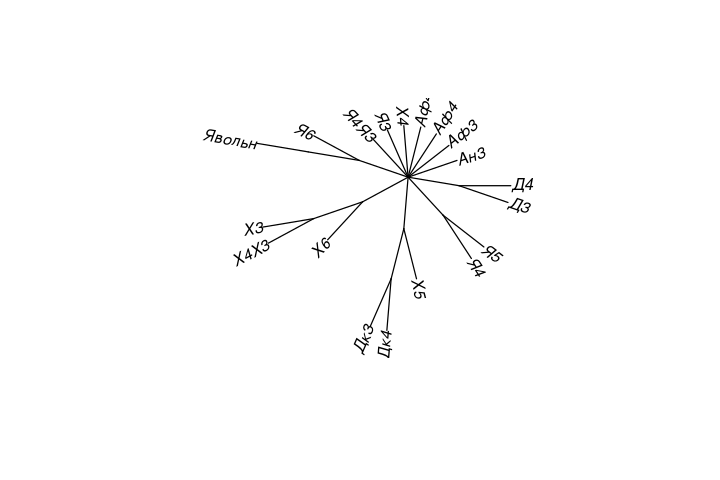

In [5]:
# unrooted consesus

consensus = ape::consensus(trees, p=0.5)

consensus %>% 
  plot(type="unrooted", lab4ut="axial", cex = 0.8)

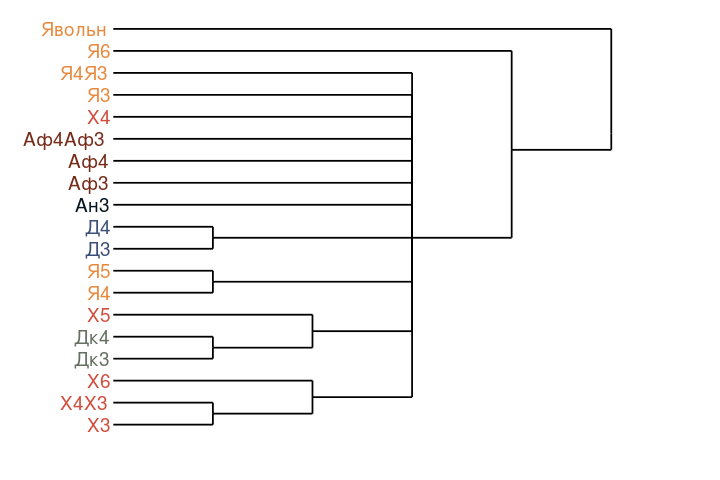

In [6]:
# convert to ggdendro object
ggtree = phylogram::as.dendrogram.phylo(consensus) %>%
  dendro_data()

# extract "meter families"

ggtree$labels = ggtree$labels %>%
  mutate(m_family = str_replace(label, "^(.*?)\\d.*", "\\1"),
         m_family = str_replace(m_family, "Явольн", "Я"))

# plot dendrogram

ggplot() + 
  geom_segment(data=ggtree$segments,aes(x,y,xend=xend, yend=yend),size=0.5) + # map segments/branches
  geom_text(data=ggtree$labels, aes(x,y,label=label, color=m_family), hjust=1.1, angle=0, size=4) + # map labels
  coord_flip() +
  scale_y_continuous(expand=c(0.2, 0)) +
  theme_dendro() +
  scale_color_paletteer_d(ghibli, MononokeMedium) +
  guides(color=F)



## 3. Distances to self

What we really expect, is not some ground thruth in metrical families, but the simialrity of meter to itself. To test this:

1) Take 3 100-lines samples per each meter;  
2) Look at clusterization "purity" (how much same-meter samples appear together)  




Joining, by = "id"


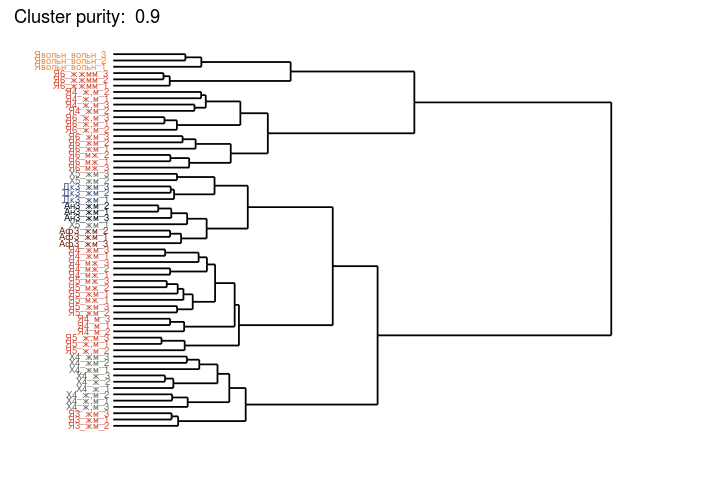

In [38]:

## take 3 samples per each meter
wide_gamma = poem_sampler(x= unique_poems  %>% unite("meter", meter:clausula),
             y=meter_claus_count,
             sample_size=100,
             n_samples=3,
             meter_count_limit=400) %>% 
    left_join(ru_gamma_separated)  %>%
#    mutate(sample = str_replace(sample,"^.*?_", "")) %>%
    group_by(topic, sample)  %>% 
    summarise(m_gamma = mean(gamma))  %>% 
    spread(key = topic, value=m_gamma)

## perpare matrix
names = wide_gamma  %>% pull(sample)
wide_matrix = wide_gamma[,-1]  %>% as.matrix()
rownames(wide_matrix) =  names


##calculate distances & build clusterization

tree = wide_matrix  %>% 
    dist(method="divergence")  %>% 
    hclust(method="ward.D2") 


n_classes = meter_claus_count  %>% 
    filter(n>=400)  %>%
    pull(meter)  %>%
    length()

classes = cutree(tree,k=n_classes)
expected = str_replace_all(names, "_\\d", "")

purity = NMF::purity(as.factor(classes), expected)

ggtree = tree  %>%
    as.dendrogram() %>%
    dendro_data()

ggtree$labels = ggtree$labels %>%
  mutate(m_family = str_replace(label, "^(.*?)\\d.*", "\\1"),
         m_family = str_replace(m_family, "Явольн", "Я"))

ggplot() +
  geom_segment(data=ggtree$segments,aes(x,y,xend=xend, yend=yend),size=0.5) + # map segments/branches
  geom_text(data=ggtree$labels, aes(x,y,label=label, color=m_family), hjust=1.1, angle=0, size=2) + # map labels
  coord_flip() +
  scale_y_continuous(expand=c(0.2, 0)) +
  theme_dendro() +
  scale_color_paletteer_d(ghibli, MononokeMedium) +
  guides(color=F) +
  labs(subtitle=paste("Cluster purity: ", round(purity,2)))

## 4. Expression of the halo

Halo should be cumulative and express general semantic trends more clearly if the larger amount of poems is availiable.
To test strength of association between meter & meaning, we:

1) take 3 samples from each meter (that has up to 400 poems) in increasingly large size (1 random poem per sample, 5 random poems, 10 random poems... etc)  
2) measure cluster purity  
3) repeat 1. and 2. 50 times per size depth;  
4) plot the clustering efficiency distriution  

In [114]:
source("src/batch_purity.R")

test = batch_purity(x=unique_poems,
                   y = meter_count,
                   z=ru_gamma_separated,
                   sample_size_steps= c(1, seq(5, 150, by=5)),
                   n_samples=3,
                   n_iterations=50,
                   meter_limit=400,
                   distance="divergence",
                   clust_method="ward.D2")

Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy


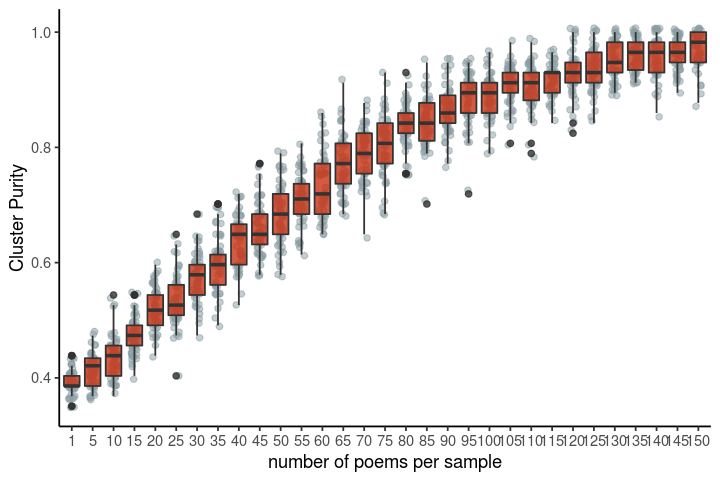

In [116]:
test  %>% 
    mutate(sample_size=as.factor(sample_size))  %>% 
ggplot(aes(sample_size, purity, group=sample_size)) +
    geom_point(alpha=0.5,position=position_jitter(w=0.15), color=paletteer_d(wesanderson,"Royal1")[1]) +
    geom_boxplot(alpha=0.8, fill=paletteer_d(wesanderson,"Royal1")[2]) +
    theme_classic() +
    labs(x="number of poems per sample",
         y="Cluster Purity")


ggsave("over9000.png",height = 6, width = 7)

## 5. Meter popularity

What if the "semantic halo" is just a mere function of a meter's popularity? In wide-spread meters (Iamb-4) it's simply more probable to sample any topic, while in rare meters there is just not enough space for expression of diverse themes. If we look at it this way, the "semantic halo" could be an effect of unequal popularity of meter + confirmation bias. Let's test this.

1) We definetly expect that the distinctivness of semantic halo will fall with the increase of amount of poems in this meter  
2) If semantic halo is **just** an effect of meter's size this fall would be indistinguishable from a random sampling any n poems (disregard meter label)  
3) If meters keep distinctive semantic traditions, they will become less distinctive in popular meters, but will not converge with random samples!

### Inequality measure

To test distinctivness of meter's semantic simple measures of inequality distribution could be used (e.g. Gini coefficient)

1) Take **all** poems , associated with specific meter  
2) Get average topic probabilities per meter  
3) Rearrange topics according to probabilities rank  
4) Measure curve "inequality" with Gini  

### Gini example

In [55]:
meter_claus_count

meter,n
<chr>,<int>
Я4_жм,5730
Х4_жм,2837
Я5_жм,2548
"Я4_ж,м",2141
Я4_мж,1935
Явольн_вольн,1878
Я5_мж,1589
Я6_жм,1189
Х5_жм,1073


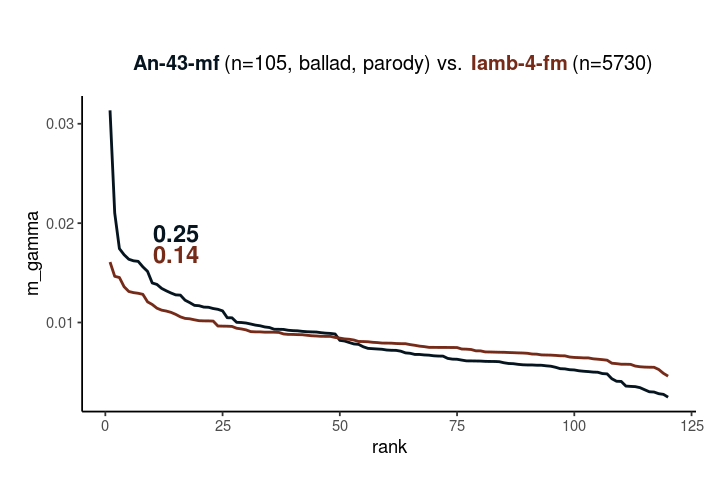

In [129]:
gini_rank = ru_gamma_separated  %>%
    unite("meter", meter:clausula)  %>% 
    filter(meter %in% c("Ан4Ан3_м м", "Я4_жм"))  %>% 
    group_by(meter, topic)  %>% 
    summarise(m_gamma = mean(gamma))  %>% 
    group_by(meter)  %>% 
    arrange(desc(m_gamma), .by_group=T)  %>% 
    mutate(rank = row_number())  %>% 
    mutate(gini=round(ineq(m_gamma),2))


#### coloring text

t1 <- textGrob(expression(" " * phantom(bold("An-43-mf")) * " (n=105, ballad, parody) vs. " * phantom(bold("Iamb-4-fm")) * " (n=5730)"),
                 x = 0.5, y = 1.1, gp = gpar(col = "black"))

t2 <- textGrob(expression(phantom(" ") * bold("An-43-mf") * phantom(" (n=105, ballad, parody) vs. Iamb-4-fm (n=5730)")),
                 x = 0.5, y = 1.1, gp = gpar(col = paletteer_d(ghibli, MononokeMedium)[1]))


t3 <- textGrob(expression(phantom(" An-43-mf (n=105, ballad, parody) vs. ") * bold("Iamb-4-fm") * phantom(" (n=5730")),
                 x = 0.5, y = 1.1, gp = gpar(col = paletteer_d(ghibli, MononokeMedium)[2]))



#### plot

p = ggplot(gini_rank, aes(rank, m_gamma, group=meter, color=meter)) + 
    geom_line(size=0.8) + 
    geom_text(data=gini_rank  %>% filter(rank == 10), 
              aes(rank+5,m_gamma+0.005, label=gini),
              size=5,fontface="bold") +
    theme_classic() +
    theme(plot.margin = unit(c(4, 1, 1, 1), "lines")) +
    scale_color_paletteer_d(ghibli, MononokeMedium) +
    annotation_custom(grobTree(t2, t1, t3)) +
    guides(color=F)
 #   labs(title = "An-43-mf (n=105) vs. Iamb-4-fm (n=5730)")

g <- ggplot_gtable(ggplot_build(p))
g$layout$clip[g$layout$name == "panel"] <- "off"

# re-draw
grid.draw(g)

### Gini for all

- take all meters that have at least 10 poems associated with them;  
- calculate gini for everyone;  
- plot log(popularity) x gini  
- expect decrease  

In [153]:
meter_subset = meter_claus_count  %>%
    filter(n > 10)

gini_rank = ru_gamma_separated  %>%
    unite("meter", meter:clausula)  %>%
    right_join(meter_subset, by="meter")  %>% 
    group_by(meter, topic,n)  %>% 
    summarise(m_gamma = mean(gamma))  %>% 
    group_by(meter)  %>% 
    arrange(desc(m_gamma), .by_group=T)  %>% 
    mutate(rank = row_number())  %>% 
    mutate(gini=round(ineq(m_gamma),3))  %>% 
    select(meter, n, gini)  %>% 
    ungroup()  %>% 
    distinct()


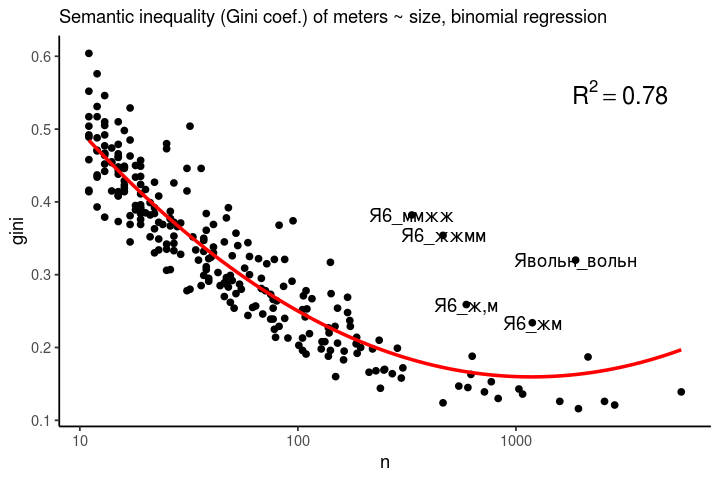

In [174]:
gini_plot  = ggplot(gini_rank, aes(n, gini))  + 
geom_point() +  
geom_smooth(aes(n, gini), method="lm", formula = y ~ poly(x, 2), se=F, color="red") +
geom_text(data=gini_rank  %>% top_n(25, n)  %>% filter(gini > 0.2), aes(label=meter)) +
scale_x_log10()  +
theme_classic() +
labs(subtitle = "Semantic inequality (Gini coef.) of meters ~ size, binomial regression") +
annotate('text', x = 3000, y=0.55, label="R^{2}==0.78", parse=T, size=5)

gini_plot

In [162]:
## model
max(gini_rank$n)
summary(lm(log(gini_rank$n) ~ poly(gini_rank$gini,2)))

[1] 5730


Call:
lm(formula = log(gini_rank$n) ~ poly(gini_rank$gini, 2))

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0743 -0.3297 -0.1106  0.1387  3.7777 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)                3.92499    0.03761 104.370  < 2e-16 ***
poly(gini_rank$gini, 2)1 -17.25133    0.59342 -29.071  < 2e-16 ***
poly(gini_rank$gini, 2)2   4.87389    0.59342   8.213 1.23e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5934 on 246 degrees of freedom
Multiple R-squared:  0.7877,	Adjusted R-squared:  0.7859 
F-statistic: 456.3 on 2 and 246 DF,  p-value: < 2.2e-16


## GRAND FINALS  

### Sem. Halo Gini vs. Random Gini. FIGHT

- now we sample poems absolutely randomly, not by meters, only size of the sample matters (and is increased up to 6000)
- at each size step repeat sampling & gini calculation 20 times

In [182]:
## sample random n poems and calculate gini
source("src/gini_sample.R")

test1 = gini_sample(unique_poems, ru_gamma_separated,
                   sample_steps = c(seq(10, 90, by=5),seq(100, 6000, by=50)),
                   n_samples=20)



At 10 size. Going strong...
At 15 size. Going strong...
At 20 size. Going strong...
At 25 size. Going strong...
At 30 size. Going strong...
At 35 size. Going strong...
At 40 size. Going strong...
At 45 size. Going strong...
At 50 size. Going strong...
At 55 size. Going strong...
At 60 size. Going strong...
At 65 size. Going strong...
At 70 size. Going strong...
At 75 size. Going strong...
At 80 size. Going strong...
At 85 size. Going strong...
At 90 size. Going strong...
At 100 size. Going strong...
At 150 size. Going strong...
At 200 size. Going strong...
At 250 size. Going strong...
At 300 size. Going strong...
At 350 size. Going strong...
At 400 size. Going strong...
At 450 size. Going strong...
At 500 size. Going strong...
At 550 size. Going strong...
At 600 size. Going strong...
At 650 size. Going strong...
At 700 size. Going strong...
At 750 size. Going strong...
At 800 size. Going strong...
At 850 size. Going strong...
At 900 size. Going strong...
At 950 size. Going strong...
At

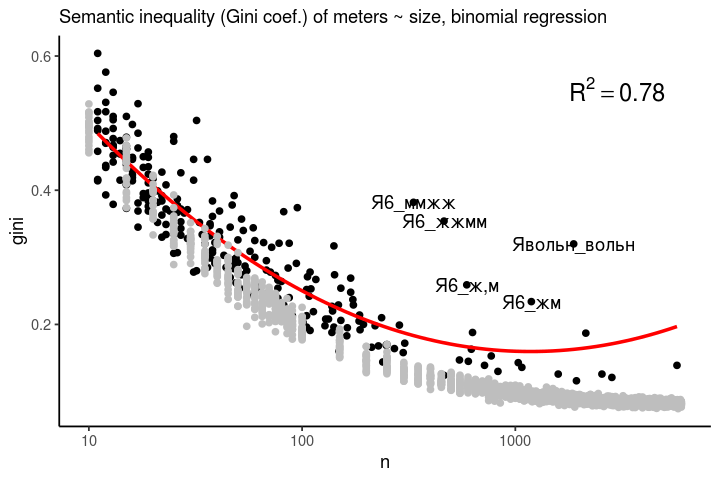

In [183]:
gini_plot + geom_point(data=test1, aes(n, gini, group=n), color="grey")

As you see, Semantic Halo (black) loses in the very first rounds to Random Gini (grey), but bounces back somewhat fast and wins the game.  

**Distinctive semantic distribution of many metrical variants cannot be achieved randomly.**